<a href="https://colab.research.google.com/github/viniciusriosfuck/dscodenation/blob/master/enem-2/predict_NotaMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENEM 2016
Vinícius Rios Fuck - 28 July 2020

----------

<a id="sec:objective"></a>
## Objective
This challenge consist in predict the grade from students on the ENEM 2016.

ENEM is an annual exam for Brazillian high school students.

## Contents

We will talk about
- [ ]  Exploratory Data Analysis (EDA)
- [ ]  Feature Engineering
  - [ ] Encoding
  - [ ] Selection
  - [ ] Imputing
- [ ]  Machine Learning
 - [ ]  Linear Regression
 - [ ]  PCA
 - [ ]  Decision Trees
 - [ ]  Random Forests
 - [ ]  XGBoost

## Load standard libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load auxiliar packages

In [2]:
try:
  import sidetable
except:
  !pip install sidetable
  import sidetable


## Auxiliar functions

### Display tables side by side

[Thanks Anton Golubev](https://https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side)

In [3]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'") \
                    .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
# Minimum example
# col = ['A','B','C','D']
# df1 = pd.DataFrame(np.arange(12).reshape((3,4)),columns=col)
# df2 = pd.DataFrame(np.arange(16).reshape((4,4)),columns=col)
# display_side_by_side([df1, df2], ['DF1', 'DF2'])

### Summarize tables (repetition patterns)

In [4]:
def summarize_data(df, max_categories=10):
    
    df_list=[]
    capt_list=[]
    
    for col in list(df.columns):
        df_freq = df.stb.freq([col])
        if len(df_freq) > max_categories:
            col_name = col + '_Repetitions'
            df_freq.rename(columns={'count':col_name}, inplace=True)
            # display(df_freq.stb.freq([col_name], style=True))
            
            capt_list.append(col_name)
            df_list.append(df_freq.stb.freq([col_name]))

        else:
            # display(df.stb.freq([col], style=True))
            capt_list.append(col)
            df_list.append(df_freq)
        
        
    return df_list, capt_list

### Histograms

In [5]:
def plot_data(df, max_categories=10, plot_col=2, size=6):

    plot_row = df.shape[1] // plot_col + df.shape[1] % plot_col
  
    fig, axes = plt.subplots(plot_row, plot_col,
                             figsize=(size*plot_col,size*plot_row/2))

    count = 0
    
    for col in list(df.columns):
        ax_row = count // plot_col
        ax_col = count % plot_col
        
        ax = axes[ax_row, ax_col]
        
        df_freq = df.stb.freq([col])
        if len(df_freq) > max_categories:
            col_name = col + '_Repetitions'
            df_freq.rename(columns={'count':col_name}, inplace=True)
            
            if len(df_freq[col_name].unique()) > max_categories:
                df_freq.hist(column=col_name,
                             ax=ax,
                             sharex=False, sharey=False)
            else:
                df_freq[col_name].value_counts().plot.bar(ax=ax, rot=0)
            
            ax.set_title(col_name)
            
            
        else:
            df[col].value_counts().plot.bar(ax=ax, rot=0)
            ax.set_title(col)
            
           
        count += 1
    fig.tight_layout()

### Pie Charts

In [6]:
def func(pct, total):
    '''
        Format label to pie chart: pct% (occurence/total)
    '''
    ocurrence = int(pct/100*total)
    return "{:.1f}%\n({:d}/{:d})".format(pct, ocurrence, total)


def plot_pie_data(df, max_categories=5, plot_col=2, size=6):
    
    nr_plots = 0
    list_col = list(df.columns)
    
    mask = np.array([False]*len(list_col))
    
    count = 0
    
    for col in list_col:
        if len(list(df[col].unique())) < max_categories:
            nr_plots += 1
            mask[count] = True
        count += 1
        
    pie_list = [i for (i, v) in zip(list_col, mask) if v]
    

    plot_row = nr_plots // plot_col + nr_plots % plot_col
  
    fig, axes = plt.subplots(plot_row, plot_col,
                             figsize=(size*plot_col,size*plot_row/2))

    count = 0
    
    for col in pie_list:
        ax_row = count // plot_col
        ax_col = count % plot_col
        
        ax = axes[ax_row, ax_col]
        
        wedges, texts, autotexts = ax.pie(df[col].value_counts(),
                                          autopct=lambda pct: func(pct, len(df)),
                                          textprops=dict(color="w"))

        ax.set_title(col)
        ax.legend(wedges, list(df[col].unique()),
          #title=col,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=10, weight="bold")
        
        count += 1
    fig.tight_layout()

### Compare two variables

In [7]:
def compare_two_variables(col1, col2, df):
  '''
    col1, col2: strings with columns names to be compared
    df: dataframe

    Method: 
      compute value_counts distribution

    out:
      histogram(col1)
      plot(col1, col2)
      dataframe

    without return

  '''
  fig, (ax1,ax2) = plt.subplots(1, 2)

  # Correlation plot
  ax1.plot(df[col1].value_counts(),
         df[col2].value_counts());

  # Histogram   
  df[col1].value_counts().hist(ax=ax2);
  
  fig.set_size_inches(12,4)
  
  # Compare value counts
  df1 = df[col1].value_counts().reset_index()
  df2 = df[col2].value_counts().reset_index()
  display(pd.merge(df1, df2, left_index=True, right_index=True))


### Plot Normal distribution, QQ, Box

Thanks to [Ertuğrul Demir](https://www.kaggle.com/datafan07/titanic-eda-and-several-modelling-approaches)


In [8]:
def plot_dist_qq_box(df, feature_name):

    """
        input: df (pd.DataFrame); feature_name (string)
        output: 3 plots
        1) distribution normal plot (Gaussian Kernel)
        2) qqplot (imput nan with mean)
        3) boxplot
    """

    import matplotlib.gridspec as gridspec
    from matplotlib.ticker import MaxNLocator
    
    # Creating a customized chart. and giving in figsize and everything.
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # Creating a grid of 3 cols and 3 rows.
    
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    
    ax1 = fig.add_subplot(grid[0, :2])
    
    # Set the title.
    
    ax1.set_title('Histogram')
    
    # Plot the histogram.
    
    sns.distplot(df.loc[:, feature_name],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # Customizing the QQ_plot.
    
    ax2 = fig.add_subplot(grid[1, :2])
    
    # Set the title.
    
    ax2.set_title('Probability Plot')
    
    # Plotting the QQ_Plot.
    
    stats.probplot(df.loc[:, feature_name].fillna(np.mean(df.loc[:, feature_name])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot.
    
    ax3 = fig.add_subplot(grid[:, 2])
    
    # Set title.
    
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    
    sns.boxplot(df.loc[:, feature_name], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{feature_name}', fontsize=24)

## Load and check the data

In [9]:
url = "https://raw.githubusercontent.com/viniciusriosfuck/dscodenation/master/enem-2/train.csv"
filename = 'train.csv'

try:
  df_train_origin = pd.read_csv(filename)
except:
  df_train_origin = pd.read_csv(url)

df_train_origin.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,D,5.0,4.0,3.0,5.0,4.0,5,5,4,3,1,4,5,NaN,A,A,A,A,A,A,A,A,A


Our data was successully imported.

In [10]:
df_train_origin.shape

(13730, 167)

Our training data presents 167 features.
Let's check if the test data contains them also.

In [11]:
url = "https://raw.githubusercontent.com/viniciusriosfuck/dscodenation/master/enem-2/test.csv"
filename = 'test.csv'

try:
  df_test = pd.read_csv(filename)
except:
  df_test = pd.read_csv(url)


df_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,D,H,H,C,B,A,NaN,A


In [12]:
df_test.shape

(4576, 47)

Despite to be successfully loaded, the test dataset doesn't contain all the columns from the training one.

Some useful informations could be retrieved from the data dictionary.

In [13]:
url = "https://github.com/viniciusriosfuck/dscodenation/blob/master/enem-2/Dicionario_Microdados_Enem_2016.xlsx?raw=true"

filename = 'Dicionario_Microdados_Enem_2016.xlsx'

try:
  data_dict = pd.read_excel(filename)
except:
  data_dict = pd.read_excel(url)


from IPython.display import display

pd.set_option('display.max_rows', 800)
display(data_dict.fillna(""))
pd.reset_option('all')  

,DICIONÁRIO DE VARIÁVEIS - ENEM 2016,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,,,,,,
1,NOME DA VARIÁVEL,Descrição,Variáveis Categóricas,,Tamanho,Tipo
2,,,Categoria,Descrição,,
3,DADOS DO PARTICIPANTE,,,,,
4,NU_INSCRICAO,Número de inscrição1,,,12,Numérica
5,NU_ANO,Ano do Enem,,,4,Numérica
6,CO_MUNICIPIO_RESIDENCIA,Código do município de residência,,,7,Numérica
7,,1º dígito: Região,,,,
8,,1º e 2º dígitos: UF,,,,
9,,"3º, 4º, 5º e 6º dígitos: Município",,,,



: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/usr/local/lib/python3.6/dist-packages/pandas/_config/config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [14]:
data_dict.head()

,DICIONÁRIO DE VARIÁVEIS - ENEM 2016,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NOME DA VARIÁVEL,Descrição,Variáveis Categóricas,NaN,Tamanho,Tipo
2,NaN,NaN,Categoria,Descrição,NaN,NaN
3,DADOS DO PARTICIPANTE,NaN,NaN,NaN,NaN,NaN
4,NU_INSCRICAO,Número de inscrição1,NaN,NaN,12,Numérica


### Train vs Test DataSet

`df_train` contains more columns than `df_test`.
It's pointless to our goal to analyse them.
We could try to investigate this missing afterwards.
But by now, let's eliminate these columns, except by the target `NU_NOTA_MT`.

In [15]:
target_name = 'NU_NOTA_MT'

y = df_train_origin[target_name].to_numpy()

In [16]:
df_train_red = df_train_origin[df_train_origin.columns & df_test.columns]
df_train_red.shape
df_train_red.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A


Let's check if all the columns from the test set are included.

In [17]:
np.mean(df_train_red.columns == df_test.columns)

1.0

Yes. Let's include the target column as the last one and check the dimensions

In [18]:
df_train0 = pd.concat([df_train_red, df_train_origin[target_name]], axis=1)
df_train0.shape

(13730, 48)

In [19]:
df_train0.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A,NaN


### Quick check at the train dataset

Let's use the auxiliar functions to have a quick overview on the train dataset.

If a variable has
* less than 10 unique values: the histograms refer to the variable self
* more than 10 unique values: the histograms refer to repeated ocurrences of values



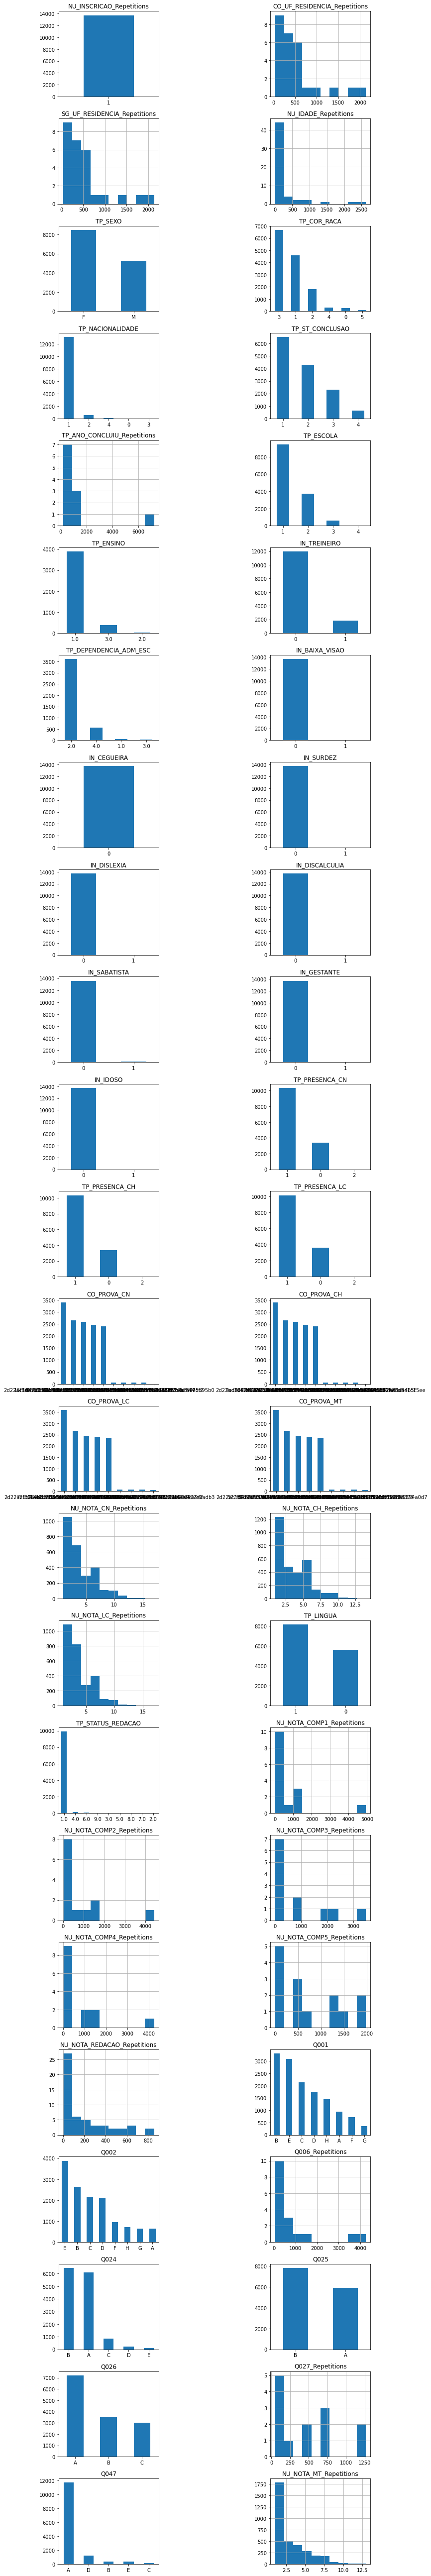

In [20]:
plot_data(df_train0)

There are piecharts for variables with less than 5 unique values.

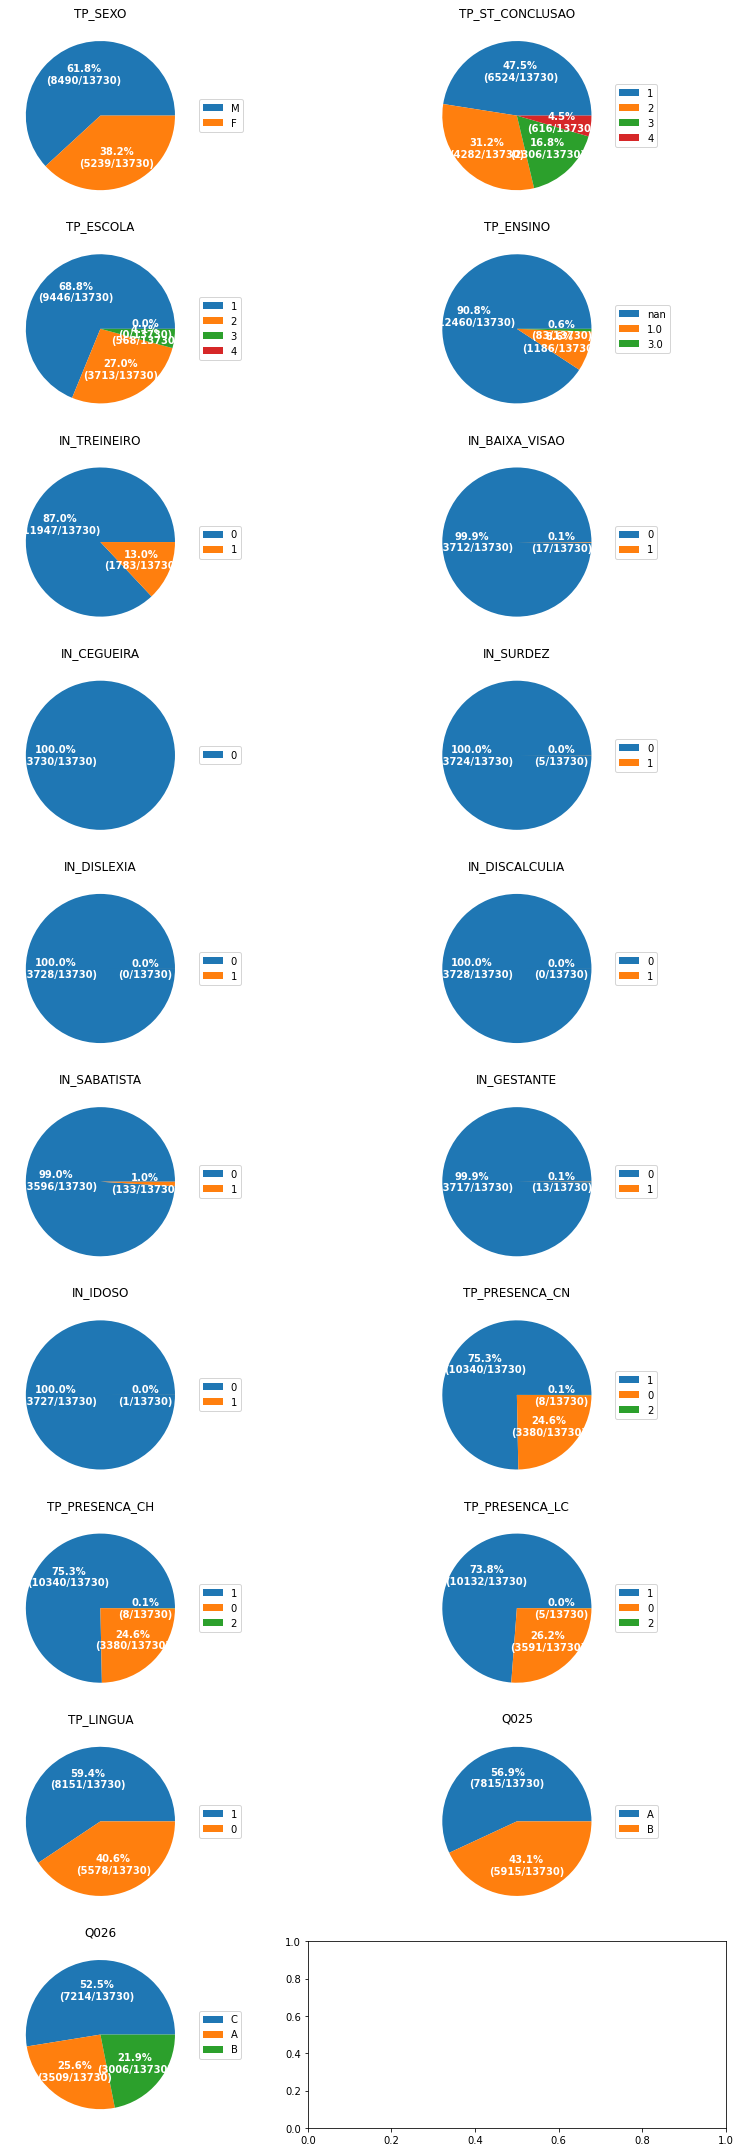

In [21]:
plot_pie_data(df_train0)

In [22]:
from IPython.display import display

pd.set_option('display.max_rows', 500)
display(df_train0.nunique().sort_values(ascending=False))
pd.reset_option('all')

NU_INSCRICAO              13730
NU_NOTA_MT                 3406
NU_NOTA_CH                 2978
NU_NOTA_LC                 2774
NU_NOTA_CN                 2692
NU_IDADE                     55
NU_NOTA_REDACAO              53
CO_UF_RESIDENCIA             27
SG_UF_RESIDENCIA             27
Q006                         17
NU_NOTA_COMP1                15
NU_NOTA_COMP5                14
NU_NOTA_COMP4                14
Q027                         13
NU_NOTA_COMP2                13
NU_NOTA_COMP3                12
TP_ANO_CONCLUIU              11
CO_PROVA_CH                  10
CO_PROVA_CN                  10
CO_PROVA_MT                   9
CO_PROVA_LC                   9
TP_STATUS_REDACAO             9
Q002                          8
Q001                          8
TP_COR_RACA                   6
Q047                          5
Q024                          5
TP_NACIONALIDADE              5
TP_ST_CONCLUSAO               4
TP_DEPENDENCIA_ADM_ESC        4
TP_ESCOLA                     4
TP_ENSIN


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/usr/local/lib/python3.6/dist-packages/pandas/_config/config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [23]:
df_train0.stb.missing(style=True)

,missing,total,percent
TP_DEPENDENCIA_ADM_ESC,9448,"13,730",68.81%
TP_ENSINO,9448,"13,730",68.81%
Q027,7373,"13,730",53.70%
NU_NOTA_REDACAO,3597,"13,730",26.20%
NU_NOTA_LC,3597,"13,730",26.20%
TP_STATUS_REDACAO,3597,"13,730",26.20%
NU_NOTA_COMP1,3597,"13,730",26.20%
NU_NOTA_COMP2,3597,"13,730",26.20%
NU_NOTA_COMP3,3597,"13,730",26.20%
NU_NOTA_COMP4,3597,"13,730",26.20%


Cross check the missing data from train and test sets.

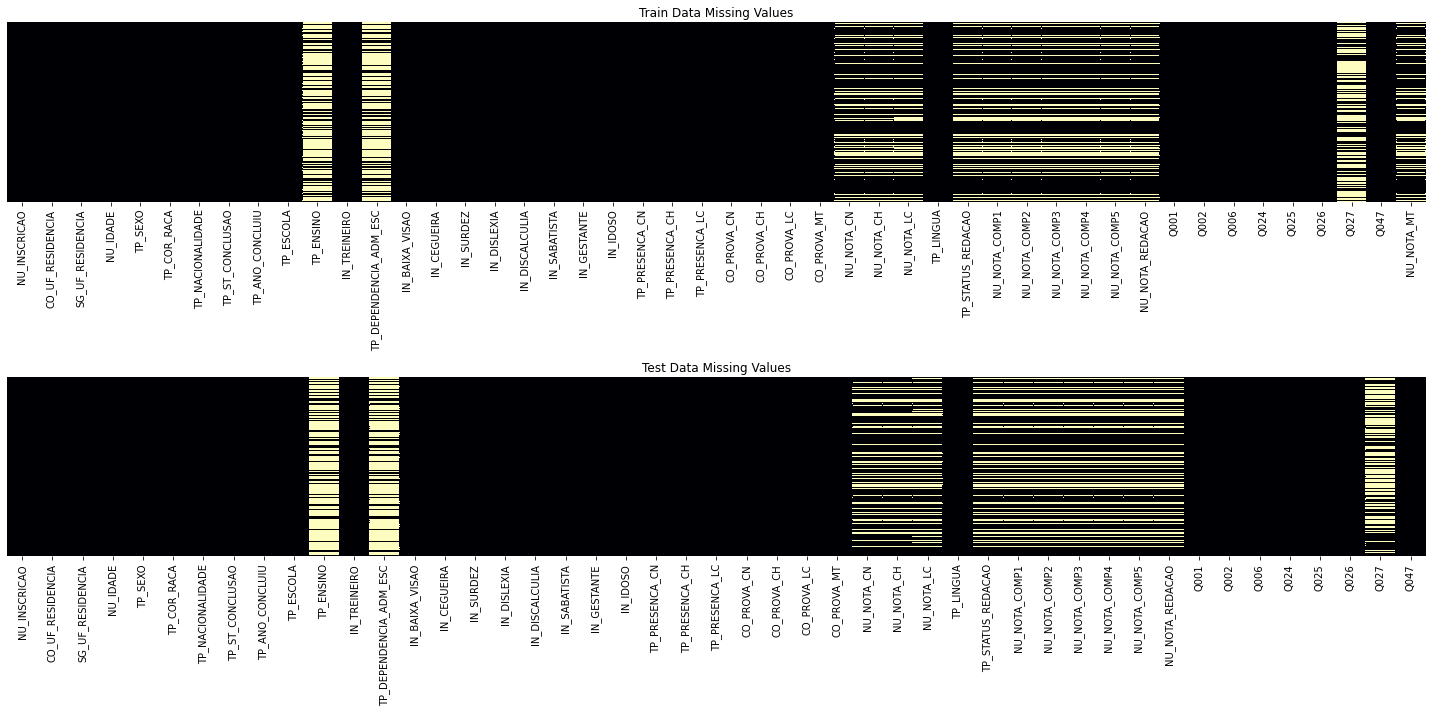

In [24]:
# Detecting missing data:

fig, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(df_train0.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[0])
sns.heatmap(df_test.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

plt.xticks(rotation=90)
fig.tight_layout()
plt.show()


In [25]:
df_list, capt_list = summarize_data(df_train0)
display_side_by_side(df_list, capt_list)

,NU_INSCRICAO_Repetitions,count,percent,cumulative_count,cumulative_percent
0,1,13730,100.000000,13730,100.000000
,CO_UF_RESIDENCIA_Repetitions,count,percent,cumulative_count,cumulative_percent
0,2138,1,3.703704,1,3.703704
1,1785,1,3.703704,2,7.407407
2,1374,1,3.703704,3,11.111111
3,912,1,3.703704,4,14.814815
4,804,1,3.703704,5,18.518519
5,637,1,3.703704,6,22.222222
6,619,1,3.703704,7,25.925926
7,594,1,3.703704,8,29.629630


## Feature selection

Let's analyse some features that could be dropped.

### Prevalent

We conclude that the features that sstart with `IN_` (except `IN_treineiro`) have almost a single outcome.
So they don't present variability for our analysis and will be discarded.
Let's stablish a threshold for this procedure.

In [26]:
def drop_prevalent(threshold=0.01):  # if 99% is one single answer drop
  
  col_to_drop_prevalent = list()
  
  for col in df_train0.columns:
    prevalent = df_train0[col].value_counts(normalize=True).max()
    if 1-prevalent < threshold:
      col_to_drop_prevalent.append(col)
  return col_to_drop_prevalent

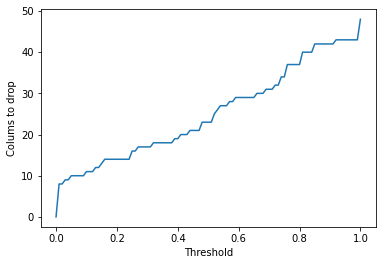

In [27]:
drop_prevalent_len = list()
drop_prevalent_list = list()
arr_threshold = np.linspace(0,1,101)
for threshold in arr_threshold:
  drop_it = drop_prevalent(threshold)
  drop_prevalent_list.append(drop_it)
  drop_prevalent_len.append(len(drop_it))

fig, ax = plt.subplots()
ax.plot(arr_threshold, drop_prevalent_len)
ax.set_xlabel('Threshold')
ax.set_ylabel('Colums to drop')
plt.show()



df = pd.DataFrame([arr_threshold,drop_prevalent_len]).T
df.columns = ['Threshold', 'Dropped columns amount']

In [28]:
try:
  import plotly.express as px
except:
  !pip install -U plotly
  import plotly.express as px

fig = px.scatter(df, x='Threshold', y='Dropped columns amount')
fig.show()

In [29]:
arr_bool=np.empty(shape=(len(df),len(df_train0.columns)))
ii=0
jj=0
for item in drop_prevalent_list:
  for col in df_train0.columns:
    arr_bool[ii,jj] = col in item
    jj+=1
  ii+=1
  jj=0

df2=pd.DataFrame(arr_bool)
df2.columns = df_train0.columns
abs(df2.sum()-101).sort_values() # Threshold to discard each column  %

IN_IDOSO                    1.0
IN_GESTANTE                 1.0
IN_SABATISTA                1.0
IN_DISCALCULIA              1.0
IN_DISLEXIA                 1.0
IN_BAIXA_VISAO              1.0
IN_CEGUEIRA                 1.0
IN_SURDEZ                   1.0
TP_STATUS_REDACAO           3.0
TP_NACIONALIDADE            5.0
TP_ENSINO                  10.0
IN_TREINEIRO               13.0
Q047                       15.0
TP_DEPENDENCIA_ADM_ESC     16.0
TP_PRESENCA_CN             25.0
TP_PRESENCA_CH             25.0
TP_PRESENCA_LC             27.0
TP_ESCOLA                  32.0
TP_SEXO                    39.0
TP_LINGUA                  41.0
Q025                       44.0
TP_ANO_CONCLUIU            48.0
Q026                       48.0
NU_NOTA_COMP1              52.0
TP_COR_RACA                52.0
TP_ST_CONCLUSAO            53.0
Q024                       54.0
NU_NOTA_COMP2              57.0
NU_NOTA_COMP4              59.0
NU_NOTA_COMP3              66.0
Q006                       69.0
Q002    

It seems reasonable to discard the columns with less than 1% distinct values.

In [30]:
list_drop_prevalent = drop_prevalent(threshold=0.01)
list_drop_prevalent

['IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO']

### Unique

`NU_INSCRICAO` corresponds to an unique primary key to identify each candidate. As could be verified in the sequence. Sol et's keep it at a separated variable `idx` and drop it from the `df_train`

In [31]:
idx_name = 'NU_INSCRICAO'

idx = df_train0[idx_name]
list_drop_unique = [idx_name]

In [32]:
df_train0.shape[0]

13730

In [33]:
df_train0[idx_name].nunique()

13730

### Almost the same variable

Despite present different codes (CO), except by the first, the exams CN and CH present the same code distributions. Therefore we could drop one of them.

,index_x,CO_PROVA_CN,index_y,CO_PROVA_CH
0,2d22ac1d42e6187f09ee6c578df187a760123ccf,3389,2d22ac1d42e6187f09ee6c578df187a760123ccf,3389
1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,2646,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,2646
2,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,2591,909237ab0d84688e10c0470e2997348aff585273,2591
3,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,2454,f48d390ab6a2428e659c37fb8a9d00afde621889,2454
4,66b1dad288e13be0992bae01e81f71eca1c6e8a6,2399,942ab3dc020af4cf53740b6b07e9dd7060b24164,2399
5,1bcdece8fb1b952552b319e4e5512bbcf540e338,66,6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,66
6,c87a85497686b3e7b3765f84a2ca95256f0f66aa,65,0fb4772fc6ee9b951ade2fbe6699cc37985c422e,65
7,69ed2ddcb151cfebe3d2ae372055335ac7c8c144,60,c95541bf218d7ff70572ca4bcb421edeff05c6d5,60
8,03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2,59,f94e97c2a5689edd5369740fde9a927e23a9465f,59
9,a27a1efea095c8a973496f0b57a24ac6775d95b0,1,d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,1


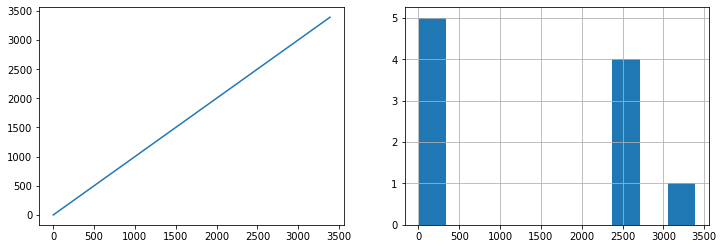

In [34]:
compare_two_variables(col1='CO_PROVA_CN',
                      col2='CO_PROVA_CH',
                      df=df_train0)

Despite present different codes (CO), except by the first, the exams LC and MT present the same code distributions. Therefore we could presumably drop one of them. We will check this on the encoding section later.

The histogram seems very similar to previous distribution. Perhaps we could drop between one of them later.

,index_x,CO_PROVA_LC,index_y,CO_PROVA_MT
0,2d22ac1d42e6187f09ee6c578df187a760123ccf,3597,2d22ac1d42e6187f09ee6c578df187a760123ccf,3597
1,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,2664,577f8968d95046f5eb5cc158608e12fa9ba34c85,2664
2,01abbb7f1a90505385f44eec9905f82ca2a42cfd,2454,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,2454
3,01af53cd161a420fff1767129c10de560cc264dd,2403,97caab1e1533dba217deb7ef41490f52e459ab01,2403
4,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,2364,767a32545304ed293242d528f54d4edb1369f910,2364
5,fa86b01f07636b15adfd66b688c79934730721a6,67,0e0082361eaceb6418bb17305a2b7912650b4783,67
6,9cbf6bf31d9d89a64ce2737ece4834fde4a95029,64,0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e,64
7,481058938110a64a272266e3892102b8ef0ca96f,63,73c5c86eef8f70263e4c5708d153cca123f93378,63
8,44b09b311799bd684b3d02463bfa99e472c6adb3,54,6d6961694e839531aec2d35bbd8552b55394a0d7,54


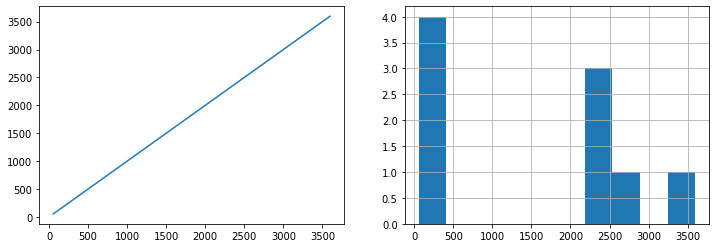

In [35]:
compare_two_variables(col1='CO_PROVA_LC',
                      col2='CO_PROVA_MT',
                      df=df_train0)   

Check `CO_UF_RESIDENCIA` and `SG_UF_RESIDENCIA` linear correlation.

,index_x,CO_UF_RESIDENCIA,index_y,SG_UF_RESIDENCIA
0,35,2138,SP,2138
1,23,1785,CE,1785
2,31,1374,MG,1374
3,29,912,BA,912
4,33,804,RJ,804
5,41,637,PR,637
6,26,619,PE,619
7,15,594,PA,594
8,21,593,MA,593
9,43,556,RS,556


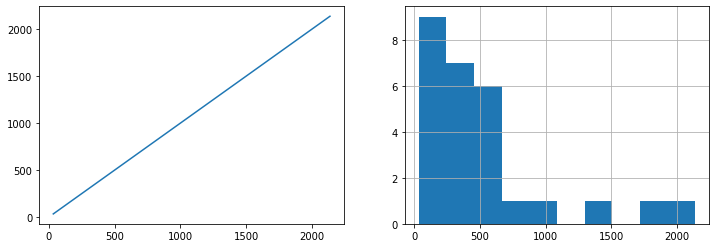

In [36]:
compare_two_variables(col1='CO_UF_RESIDENCIA',
                      col2='SG_UF_RESIDENCIA',
                      df=df_train0)

The exams `CN` and `CH` were taken on the same day inferred by looking at the same distributions. Therefore we could drop one of them.


,index_x,TP_PRESENCA_CN,index_y,TP_PRESENCA_CH
0,1,10341,1,10341
1,0,3380,0,3380
2,2,9,2,9


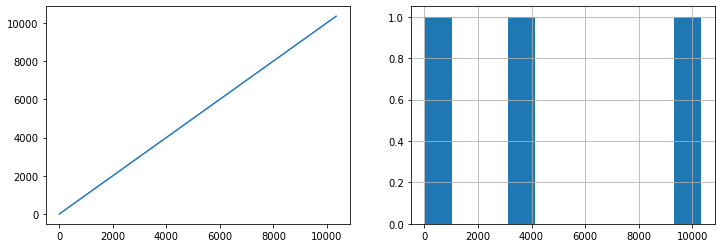

In [37]:
compare_two_variables(col1='TP_PRESENCA_CN',
                      col2='TP_PRESENCA_CH',
                      df=df_train0)


In [38]:
np.mean(df_train0['TP_PRESENCA_CN'] == df_train0['TP_PRESENCA_CH'])

1.0

In [39]:
list_drop_almost_same = ['CO_PROVA_LC', 'CO_PROVA_CH', 'TP_PRESENCA_CH', 
                         'SG_UF_RESIDENCIA']

### Drop all together

In [40]:
list_drop = list_drop_prevalent + list_drop_unique + list_drop_almost_same
df_train1 = df_train0.drop(list_drop, axis=1)
df_train1

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,TP_PRESENCA_CN,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,43,24,M,1,1,1,4,1,NaN,0,NaN,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A,399.4
1,23,17,F,3,1,2,0,2,1.0,0,2.0,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A,459.8
2,23,21,F,3,1,3,0,1,NaN,0,NaN,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A,NaN
3,33,25,F,0,1,1,9,1,NaN,0,NaN,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D,NaN
4,13,28,M,2,1,1,4,1,NaN,0,NaN,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,35,20,M,1,1,1,3,1,NaN,0,NaN,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,97caab1e1533dba217deb7ef41490f52e459ab01,438.2,419.7,394.5,0,1.0,120.0,120.0,80.0,80.0,40.0,440.0,E,E,G,B,B,B,C,A,403.2
13726,26,33,F,3,2,1,10,1,NaN,0,NaN,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,423.8,557.9,533.0,1,1.0,120.0,120.0,120.0,120.0,80.0,560.0,A,A,C,A,B,B,I,A,452.4
13727,43,15,F,1,1,3,0,1,NaN,1,NaN,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,460.5,528.9,569.3,0,1.0,120.0,120.0,120.0,120.0,120.0,600.0,C,G,B,A,B,A,NaN,A,398.0
13728,33,36,M,3,1,4,0,1,NaN,0,NaN,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,767a32545304ed293242d528f54d4edb1369f910,422.5,621.7,569.0,1,1.0,100.0,100.0,80.0,80.0,100.0,460.0,B,D,G,B,B,C,E,A,386.6


## Encoding

### Exam codes: CO_CN and CO_MT

In [41]:
dict_CO_CN = dict(enumerate(list(
    df_train0['CO_PROVA_CN'].value_counts().index)))
#dict_CO_CN = {f'CO_CN_{k}': v for k, v in dict_CO_CN.items()}
dict_CO_CN = {f'{v}': k for k, v in dict_CO_CN.items()}
dict_CO_CN

{'03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2': 8,
 '16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2': 1,
 '1bcdece8fb1b952552b319e4e5512bbcf540e338': 5,
 '2d22ac1d42e6187f09ee6c578df187a760123ccf': 0,
 '66b1dad288e13be0992bae01e81f71eca1c6e8a6': 4,
 '69ed2ddcb151cfebe3d2ae372055335ac7c8c144': 7,
 'a27a1efea095c8a973496f0b57a24ac6775d95b0': 9,
 'b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7': 2,
 'c8328ebc6f3238e06076c481bc1b82b8301e7a3f': 3,
 'c87a85497686b3e7b3765f84a2ca95256f0f66aa': 6}

In [42]:
dict_CO_MT = dict(enumerate(list(
    df_train0['CO_PROVA_MT'].value_counts().index)))
# dict_CO_MT = {f'CO_MT_{k}': v for k, v in dict_CO_MT.items()}
dict_CO_MT = {f'{v}': k for k, v in dict_CO_MT.items()}
dict_CO_MT

{'0e0082361eaceb6418bb17305a2b7912650b4783': 5,
 '0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e': 6,
 '2d22ac1d42e6187f09ee6c578df187a760123ccf': 0,
 '577f8968d95046f5eb5cc158608e12fa9ba34c85': 1,
 '6d6961694e839531aec2d35bbd8552b55394a0d7': 8,
 '73c5c86eef8f70263e4c5708d153cca123f93378': 7,
 '767a32545304ed293242d528f54d4edb1369f910': 4,
 '81d0ee00ef42a7c23eb04496458c03d4c5b9c31a': 2,
 '97caab1e1533dba217deb7ef41490f52e459ab01': 3}

#### Check if CO_PROVA could be dropped

With this check we become sure about the possibility to drop the CO_PROVA columns from the repeated ones, since the exams
 * `MT` is taken on the same day as `LC`
 * `CH` is taken on the same day as `CN`



In [43]:
dict_CO_CH = dict(enumerate(list(
    df_train0['CO_PROVA_CH'].value_counts().index)))
dict_CO_CH = {f'{v}': k for k, v in dict_CO_CH.items()}

In [44]:
dict_CO_LC = dict(enumerate(list(
    df_train0['CO_PROVA_LC'].value_counts().index)))
dict_CO_LC = {f'{v}': k for k, v in dict_CO_LC.items()}

In [45]:
np.mean(
    df_train0['CO_PROVA_CN'].map(dict_CO_CN) 
    == df_train0['CO_PROVA_CH'].map(dict_CO_CH)
    )

1.0

In [46]:
np.mean(
    df_train0['CO_PROVA_LC'].map(dict_CO_LC) 
    == df_train0['CO_PROVA_MT'].map(dict_CO_MT)
    )

1.0


**SUPER IMPORTANT NOTE**

This give us a powerful insight:
> if the candidate doesn't take presence on the `LC` exam, he won't have a `NU_NOTA_MT`, because he didn't make this exam.

From the data dictionary

* 0: miss the exam
* 1: present on the exam
* 2: eliminated on the exam

# TODO CHECK THIS

&

OR

Intersection

REMIND

False == False (True)

In [47]:
mask_LC_0_MT_NA = (
    (df_train0['TP_PRESENCA_LC']==0)
    == (df_train0[target_name].isna())
)
np.mean(mask_LC_0_MT_NA)

0.9996358339402768

In [48]:
mask_LC_02_MT_NA = (
    (
        (df_train0['TP_PRESENCA_LC']==0) 
        | (df_train0['TP_PRESENCA_LC']==2)
        )
    == (df_train0[target_name].isna())
)
np.mean(mask_LC_02_MT_NA)

1.0

We have another trend, if the candidate doesn't make or is disclassified on the `CN` exam, he probably won't have a `NU_NOTA_MT`;

This could be explained, since the first exam is the `CN`.
Therefore only afterwards the `MT` would be taken.

If the candidate missed the first one or was disclassified on it, he probably won't have the desire to do the second exam.

On the train set, only 2% of the candidates on such situation have done the second exam.

In [49]:
mask_CN_0_MT_NA = (
    (df_train0['TP_PRESENCA_CN']==0)
    & (df_train0[target_name].isna())
)
round(1-np.mean(mask_CN_0_MT_NA), 4)

0.7562

In [50]:
mask_CN_02_MT_NA = (
    (
        (df_train0['TP_PRESENCA_CN']==0) 
        | (df_train0['TP_PRESENCA_CN']==2)
        )
    & (df_train0[target_name].isna())
)
round(1-np.mean(mask_CN_02_MT_NA), 4)

0.7558

In [51]:
False & False

False

In [52]:
df_train1[['TP_PRESENCA_CN', 'TP_PRESENCA_LC', 'NU_NOTA_CN',
           'NU_NOTA_CH', 'NU_NOTA_LC', target_name]].loc[mask_CN_02_MT_NA]


,TP_PRESENCA_CN,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
2,0,0,NaN,NaN,NaN,NaN
3,0,0,NaN,NaN,NaN,NaN
4,0,0,NaN,NaN,NaN,NaN
9,0,0,NaN,NaN,NaN,NaN
13,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
13711,0,0,NaN,NaN,NaN,NaN
13713,0,0,NaN,NaN,NaN,NaN
13715,0,0,NaN,NaN,NaN,NaN
13716,0,0,NaN,NaN,NaN,NaN


### Questions: Q_OXX

In [53]:
import string
# select the question columns
list_q = df_train0.loc[:, df_train0.columns.str.startswith('Q0')].columns
# generate an alphabet with capital letter
dict_q = {ch: n for n, ch in enumerate(string.ascii_uppercase)}
dict_q

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

### Gender

In [54]:
dict_sexo = { "F":1,'M':0}  # keep alphabetic order


### UF

In [55]:
co = df_train0['CO_UF_RESIDENCIA'].unique()
sg = df_train0['SG_UF_RESIDENCIA'].unique()
map_co_sg = dict(zip(co,sg))

### Encode all together

In [56]:
# Exam CO_
df_train1['CO_PROVA_MT'] = df_train0['CO_PROVA_MT'].map(dict_CO_MT)
df_train1['CO_PROVA_CN'] = df_train0['CO_PROVA_CN'].map(dict_CO_CN)

# Questions
for col in list_q:
  df_train1[col] = df_train0[col].map(dict_q)

# Gender
df_train1['TP_SEXO'] = df_train0['TP_SEXO'].map(dict_sexo)

# SG UF was dropped, CO already encoded
df_train1

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,TP_PRESENCA_CN,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,43,24,0,1,1,1,4,1,NaN,0,NaN,1,1,1,3,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,3,3,2,0,0,2,7.0,0,399.4
1,23,17,1,3,1,2,0,2,1.0,0,2.0,1,1,2,3,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,0,0,1,0,0,0,NaN,0,459.8
2,23,21,1,3,1,3,0,1,NaN,0,NaN,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,2,0,0,0,NaN,0,NaN
3,33,25,1,0,1,1,9,1,NaN,0,NaN,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,4,4,2,1,2,5.0,3,NaN
4,13,28,0,2,1,1,4,1,NaN,0,NaN,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,2,0,0,1,5.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,35,20,0,1,1,1,3,1,NaN,0,NaN,1,1,4,3,438.2,419.7,394.5,0,1.0,120.0,120.0,80.0,80.0,40.0,440.0,4,4,6,1,1,1,2.0,0,403.2
13726,26,33,1,3,2,1,10,1,NaN,0,NaN,1,1,2,2,423.8,557.9,533.0,1,1.0,120.0,120.0,120.0,120.0,80.0,560.0,0,0,2,0,1,1,8.0,0,452.4
13727,43,15,1,1,1,3,0,1,NaN,1,NaN,1,1,3,2,460.5,528.9,569.3,0,1.0,120.0,120.0,120.0,120.0,120.0,600.0,2,6,1,0,1,0,NaN,0,398.0
13728,33,36,0,3,1,4,0,1,NaN,0,NaN,1,1,4,4,422.5,621.7,569.0,1,1.0,100.0,100.0,80.0,80.0,100.0,460.0,1,3,6,1,1,2,4.0,0,386.6


## Correlations

In [57]:
#correlation matrix
corr_mat = df_train1.corr()

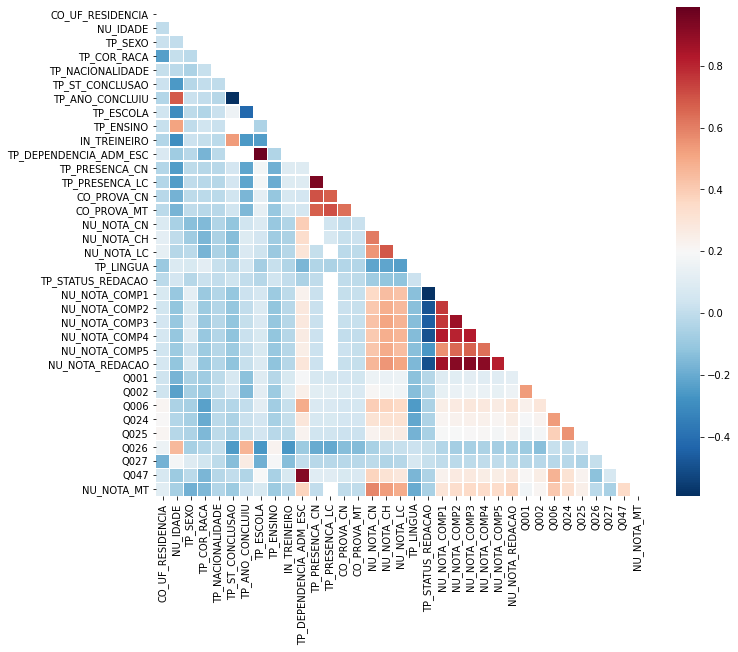

In [58]:
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap='RdBu_r', vmax=.99, #center=0,
            square=True, linewidths=.5);#, cbar_kws={"shrink": .5});

In [59]:
corr_mat.where(mask).T.style.background_gradient(cmap='RdBu_r').set_precision(2)

### Most correlated variables

In [60]:
corr_mat_abs = corr_mat.abs()

sol = (corr_mat_abs
       .where(np.triu(np.ones(corr_mat_abs.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

for index, value in sol.items():
  pass

sol.round(4).head(10)


TP_ESCOLA               TP_DEPENDENCIA_ADM_ESC    0.9753
TP_PRESENCA_CN          TP_PRESENCA_LC            0.9434
NU_NOTA_COMP3           NU_NOTA_REDACAO           0.9258
TP_DEPENDENCIA_ADM_ESC  Q047                      0.9229
NU_NOTA_COMP2           NU_NOTA_REDACAO           0.9183
NU_NOTA_COMP4           NU_NOTA_REDACAO           0.9145
NU_NOTA_COMP2           NU_NOTA_COMP3             0.8754
NU_NOTA_COMP1           NU_NOTA_REDACAO           0.8627
NU_NOTA_COMP3           NU_NOTA_COMP4             0.8272
NU_NOTA_COMP1           NU_NOTA_COMP4             0.8245
dtype: float64

### Most correlated variables to the target

This is a absolute sort order for correlation between the features and the target.

In [61]:
# Listing most related continuous values to target.
s = corr_mat[target_name]
s_ord = s.reindex(s.abs().sort_values(ascending=False).index).iloc[1:]
s_ord.to_frame().style.background_gradient(cmap='RdBu_r').set_precision(2)

,NU_NOTA_MT
NU_NOTA_CN,0.58
NU_NOTA_CH,0.53
NU_NOTA_LC,0.49
Q006,0.41
NU_NOTA_REDACAO,0.38
TP_DEPENDENCIA_ADM_ESC,0.37
NU_NOTA_COMP3,0.35
Q047,0.35
NU_NOTA_COMP5,0.34
NU_NOTA_COMP4,0.34


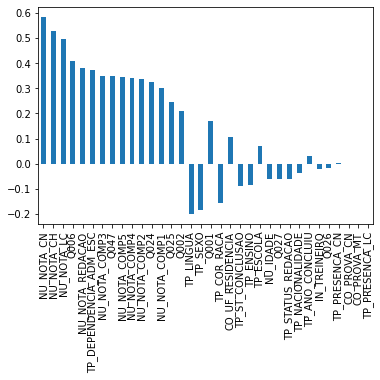

In [62]:
s_ord.plot(kind='bar');

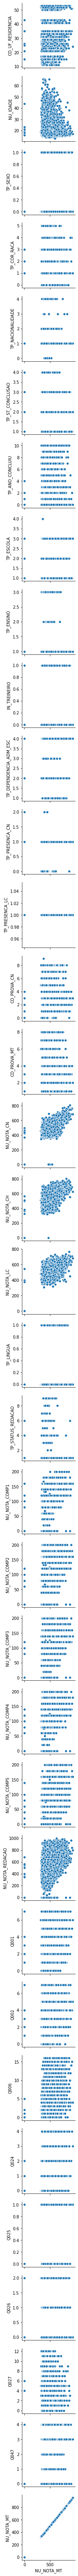

In [63]:
pp = sns.pairplot(data=df_train1,
                  x_vars=target_name,
                  y_vars=df_train1.columns)

## Baseline

## Scratch

In [64]:
df_train1.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,TP_PRESENCA_CN,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,4282.000000,13730.000000,4282.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,6357.000000,13730.000000,10133.000000
mean,30.736708,21.593809,0.618427,2.185652,1.048871,1.782666,2.146176,1.353532,1.178888,0.129862,2.259692,0.754479,0.738747,1.923307,1.881209,473.495155,529.661087,516.472841,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258,2.988128,3.093955,2.975892,0.671449,0.569192,0.693445,3.844423,0.398762,482.497928
std,9.862405,7.043654,0.485790,1.007285,0.258895,0.880734,3.217328,0.558472,0.565490,0.336163,0.698586,0.431932,0.440162,1.561571,1.570525,71.093674,73.726344,68.688190,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758,2.023661,1.778523,2.773124,0.726335,0.495207,0.806536,2.540395,1.027900,99.826323
min,11.000000,13.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,419.900000,480.400000,468.100000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,408.900000
50%,31.000000,19.000000,1.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,459.800000,532.000000,520.900000,1.000000,1.000000,120.000000,120.000000,120.000000,120.000000,80.000000,540.000000,3.000000,3.000000,2.000000,1.000000,1.000000,0.000000,4.000000,0.000000,461.200000
75%,35.000000,23.000000,1.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,3.000000,514.500000,581.200000,564.900000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,5.000000,0.000000,537.600000
max,53.000000,67.000000,1.000000,5.000000,4.000000,4.000000,10.000000,4.000000,3.000000,1.000000,4.000000,2.000000,2.000000,9.000000,8.000000,806.400000,807.000000,763.600000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000,7.000000,7.000000,16.000000,4.000000,1.000000,2.000000,12.000000,4.000000,952.000000


In [65]:
df_train1[['TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'IN_TREINEIRO', 
           target_name]].corr()

,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,IN_TREINEIRO,NU_NOTA_MT
TP_ST_CONCLUSAO,1.000000,-0.592834,0.533983,-0.087869
TP_ANO_CONCLUIU,-0.592834,1.000000,-0.257710,0.029039
IN_TREINEIRO,0.533983,-0.257710,1.000000,-0.022287
NU_NOTA_MT,-0.087869,0.029039,-0.022287,1.000000


,index_x,TP_PRESENCA_CN,index_y,TP_PRESENCA_LC
0,1,10341,1,10133
1,0,3380,0,3592
2,2,9,2,5


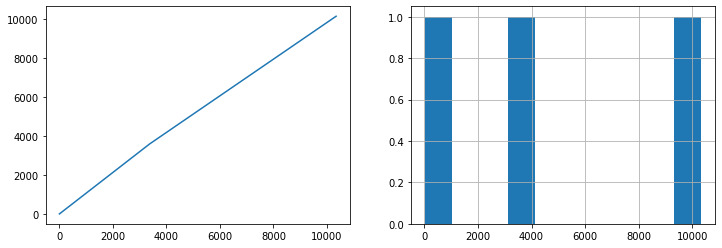

In [66]:
compare_two_variables(col1='TP_PRESENCA_CN',
                      col2='TP_PRESENCA_LC',
                      df=df_train0)

,index_x,TP_ESCOLA,index_y,TP_DEPENDENCIA_ADM_ESC
0,1,9447,2.0,3611
1,2,3713,4.0,569
2,3,569,1.0,64
3,4,1,3.0,38


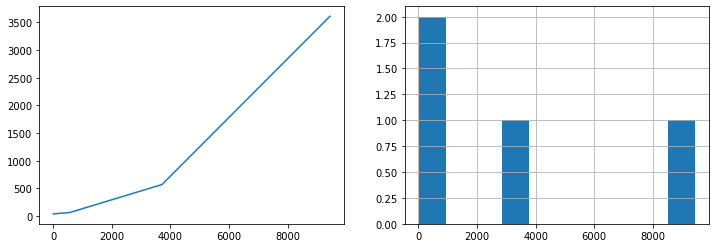

In [67]:
compare_two_variables(col1='TP_ESCOLA',
                      col2='TP_DEPENDENCIA_ADM_ESC',
                      df=df_train0)

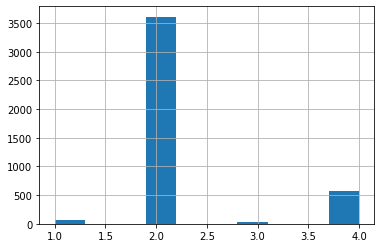

In [68]:
df_train0['TP_DEPENDENCIA_ADM_ESC'].hist();

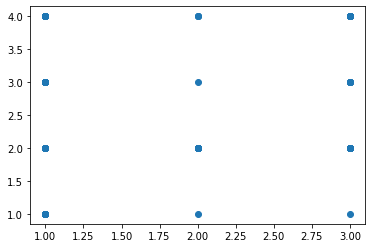

In [69]:
plt.scatter(df_train1['TP_ENSINO'], df_train1['TP_DEPENDENCIA_ADM_ESC']);

In [70]:
df_train1[['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ESCOLA', 
           target_name]].corr()

,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_ESCOLA,NU_NOTA_MT
TP_ENSINO,1.000000,-0.037207,-0.047195,-0.086353
TP_DEPENDENCIA_ADM_ESC,-0.037207,1.000000,0.975328,0.373233
TP_ESCOLA,-0.047195,0.975328,1.000000,0.069304
NU_NOTA_MT,-0.086353,0.373233,0.069304,1.000000


In [71]:
df_train1['TP_ENSINO'].isna().sum()/df_train1.shape[0]


0.6881281864530225

In [72]:
   # plot_cross(df_train, target_name)

# Variáveis disponíveis no test_set.csv

df_train = df_train[['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047']]





In [73]:
test_col = list(df_test.columns)
test_col.append(target_name)

In [74]:
df_train = df_train_origin[test_col]

In [75]:

# selective analysis with pandas profiler help: RelatorioEnem00
# remove variables with little variance
df_train = df_train[[idx_name,
                     target_name,'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC',
                     'NU_NOTA_REDACAO','NU_NOTA_COMP1','NU_NOTA_COMP5',
                     'TP_LINGUA','TP_SEXO','TP_COR_RACA','TP_NACIONALIDADE',
                     'SG_UF_RESIDENCIA','NU_IDADE',
                     'TP_ST_CONCLUSAO','TP_ESCOLA',
                     'Q001','Q002','Q006','Q024','Q025','Q026','Q047']]

1.   Removidas variáveis rotuladas quase que totalmente em uma categoria (IN_...)
2.   Removida variável Q027, apenas 50% dos dados (tanto no train quanto no test_set)
3.   Removida variável TP_ENSINO por apresentar muitos dados faltantes
4.   Removida variável TP_DEPENDENCIA_ADM_ESC por ser altamente correlacionada com TP_ESCOLA e apresentar menos dados
5.   Removidas variáveis TP_PRESENCA, pois ausência de dados em NU_NOTA, corresponde a ausência na prova
6.   Removidas variáveis CO_PROVA, pois correspondem ao tipo de prova e não deveriam influir na nota
7.   Removida variável CO_UF_RESIDENCIA, pois equivale a SG_UF_RESIDENCIA (mantida)
8.   Removidas variáveis TP_ANO_CONCLUIU (muitos dados faltantes), IN_TREINEIRO, pois manteve-se TP_ST_CONCLUSAO que contém a essência de tal informação que poderia ser eventualmente usada para prever NU_NOTA_MT
9.   Removidas variáveis TP_ENSINO, TP_DEPENDENCIA_ADM_ESC,  pois manteve-se TP_ESCOLA que contém tal informação
10.  Removidas variáveis NU_NOTA_COMP2, NU_NOTA_COMP3, NU_NOTA_COMP4, pois são altamente correlacionadas com NU_NOTA_REDACAO, apresentando praticamente a mesma distribuição, obs: mantidas: NU_NOTA_COMP1 e NU_NOTA_COMP5, por apesar de também comporem a nota da redação, apresentam distribuição distinta
11.   Removida TP_STATUS_REDACAO, por apresentar poucos valores distintos de ok, e os valores faltantes corresponderem a ausências, passíveis de ser capturadas pela NU_NOTA_REDACAO
12.   Removido Q026 não apresentada dependência com NU_NOTA_MT (boxplot)

Regras a considerar
1.   Se faltar NU_NOTA_LC falta NU_NOTA_MT, pois LC mesmo dia que MT
2.   NU_NOTA_MT mínima no train_set, exceto zero ou vazio, 320.5

In [76]:
# instalando o pandas profiling
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# import o ProfileReport
# from pandas_profiling import ProfileReport
# executando o profile
# profile = ProfileReport(df_train, title='Relatório - Pandas Profiling', html={'style':{'full_width':True}})
# profile
# salvando o relatório no disco
# profile.to_file(output_file="RelatorioEnem.html")

# Analysing target: 'NU_NOTA_MT'



In [77]:
#descriptive statistics summary
df_train_origin[target_name].describe()

count    10133.000000
mean       482.497928
std         99.826323
min          0.000000
25%        408.900000
50%        461.200000
75%        537.600000
max        952.000000
Name: NU_NOTA_MT, dtype: float64

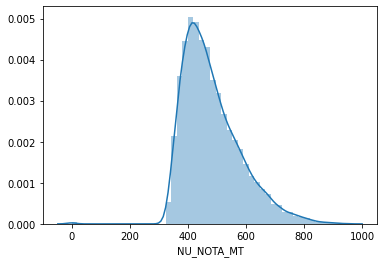

In [78]:
#histogram
sns.distplot(df_train_origin[target_name]);

In [79]:
#skewness and kurtosis
print("Skewness: %f" % df_train_origin[target_name].skew())
print("Kurtosis: %f" % df_train_origin[target_name].kurt())

print("Minimum but zero: %f" 
      % df_train_origin.loc[df_train_origin[target_name]>0, target_name].min())

Skewness: 0.920690
Kurtosis: 1.422503
Minimum but zero: 320.500000


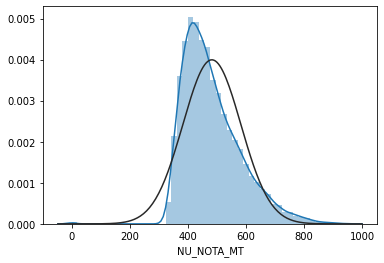

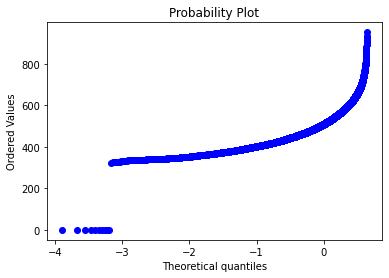

In [80]:
#histogram and normal probability plot
sns.distplot(df_train_origin[target_name], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_origin[target_name], plot=plt)

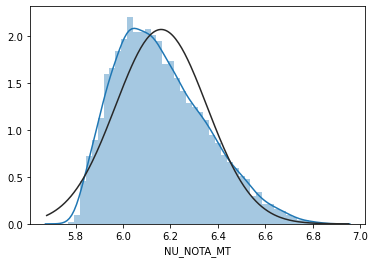

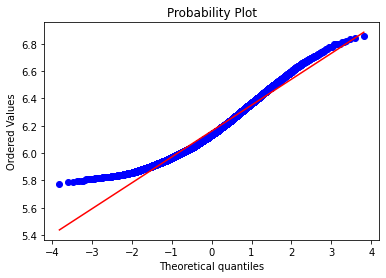

In [81]:
#applying log transformation
mask = df_train_origin[target_name]>0

#transform data
df_train_origin.loc[mask,target_name] = np.log(
                                    df_train_origin.loc[mask,target_name])

#histogram and normal probability plot
sns.distplot(df_train_origin.loc[mask, target_name], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_origin.loc[mask, target_name],
                     plot=plt)

### Relationship with categorical features

In [112]:
def cat_feat_rel(df, feature_name, target_name):
  data = pd.concat([df[target_name], df[feature_name]], axis=1)
  f, ax = plt.subplots(figsize=(8, 6))
  fig = sns.boxplot(x=feature_name, y=target_name, data=data)
  fig.axis(ymin=0, ymax=1_000);

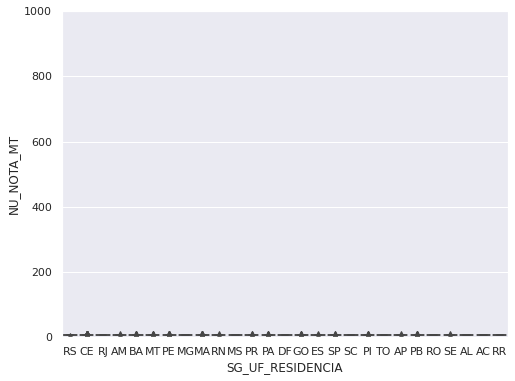

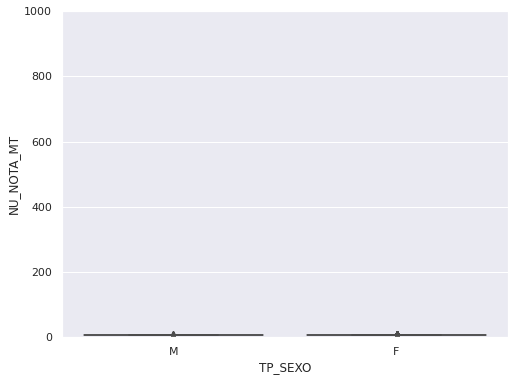

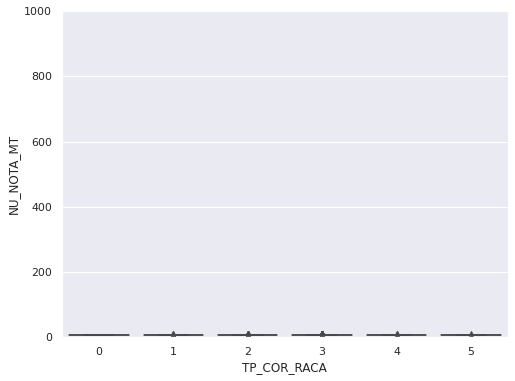

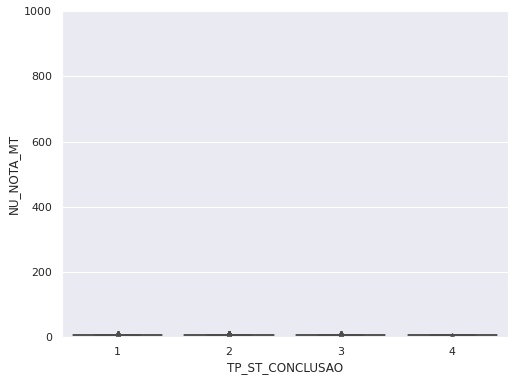

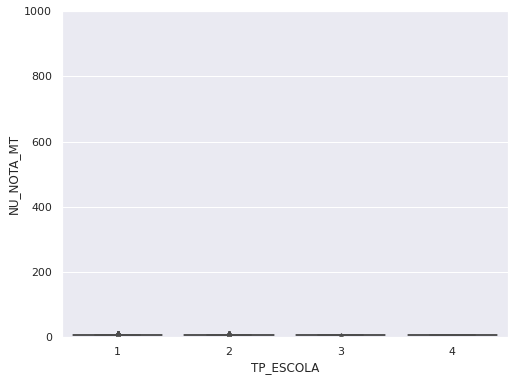

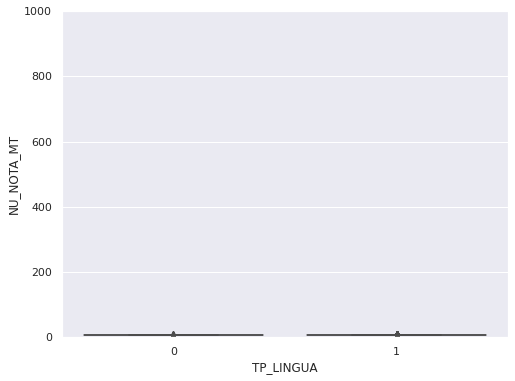

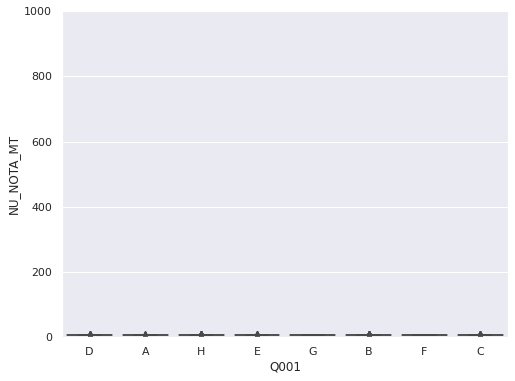

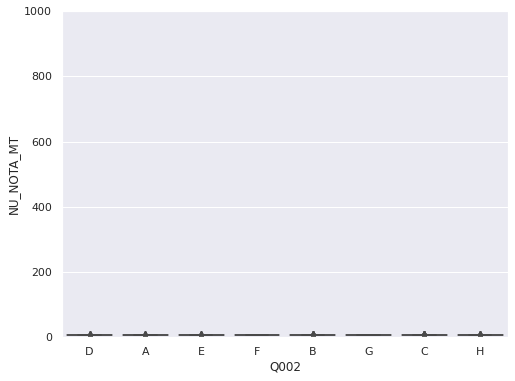

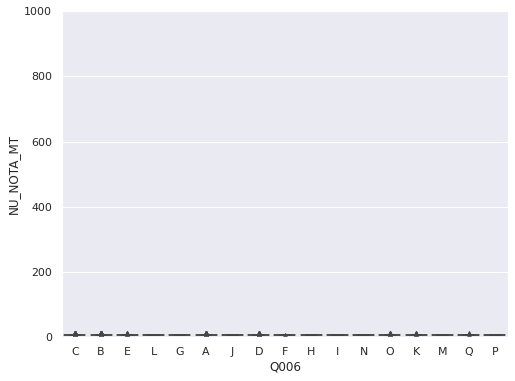

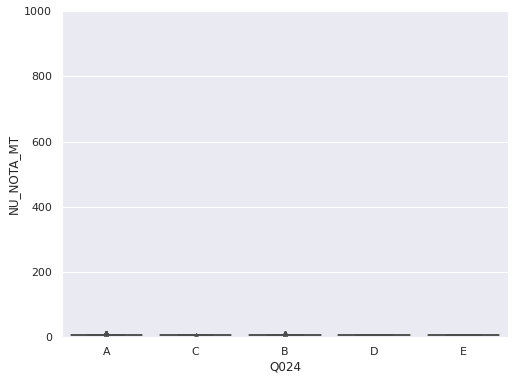

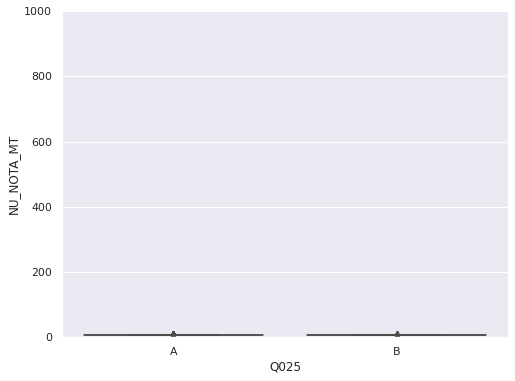

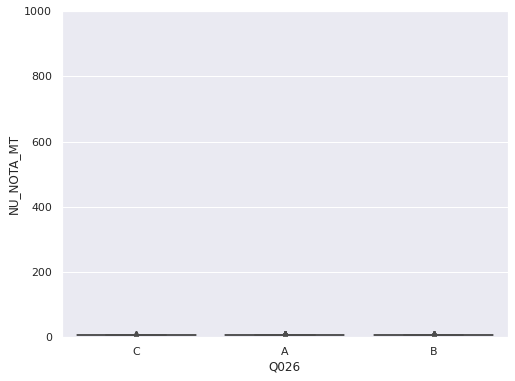

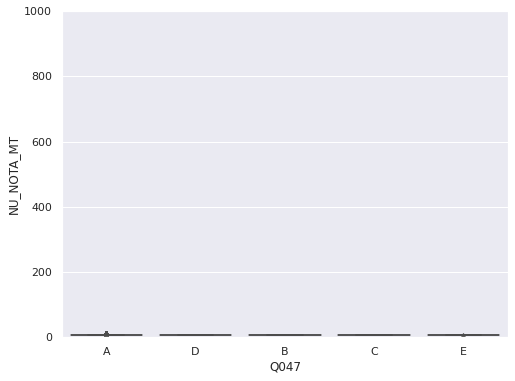

In [113]:
cat_col_list = ['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA',
                'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_LINGUA',
                'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026',
                'Q047']

for col in cat_col_list:
  cat_feat_rel(df_train_origin, col, target_name)


# Correlation

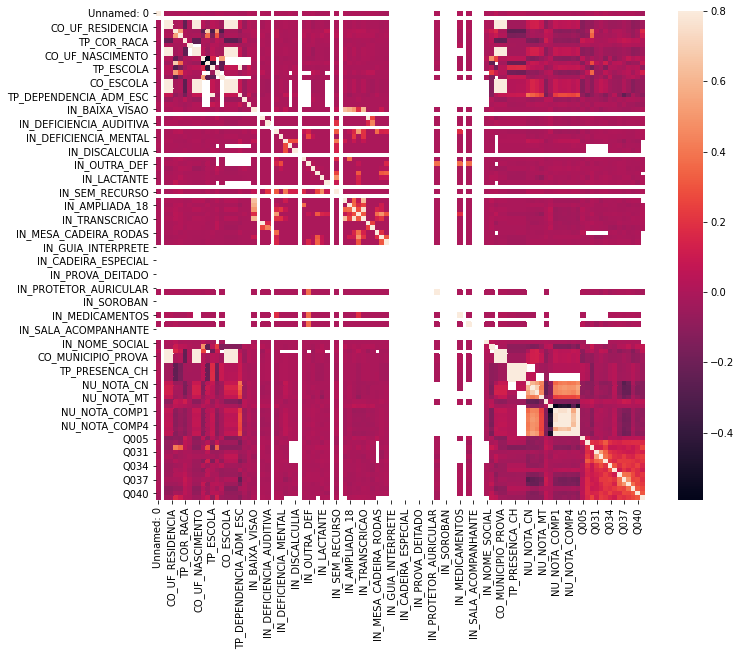

In [84]:
#correlation matrix
corrmat = df_train_origin.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

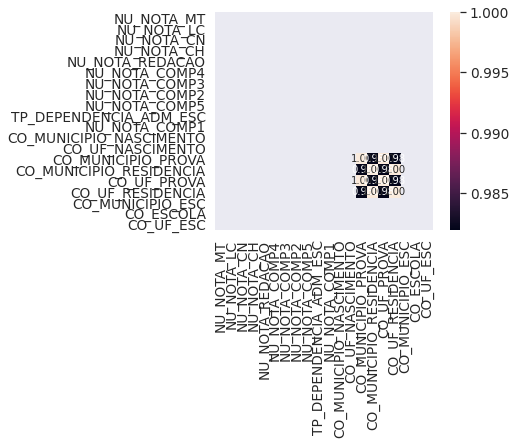

In [85]:
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, target_name)[target_name].index
cm = np.corrcoef(df_train_origin[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, 
                 xticklabels=cols.values, yticklabels=cols.values)
plt.show()

#### Scatter plots between 'NU_NOTA_MT' and correlated variables

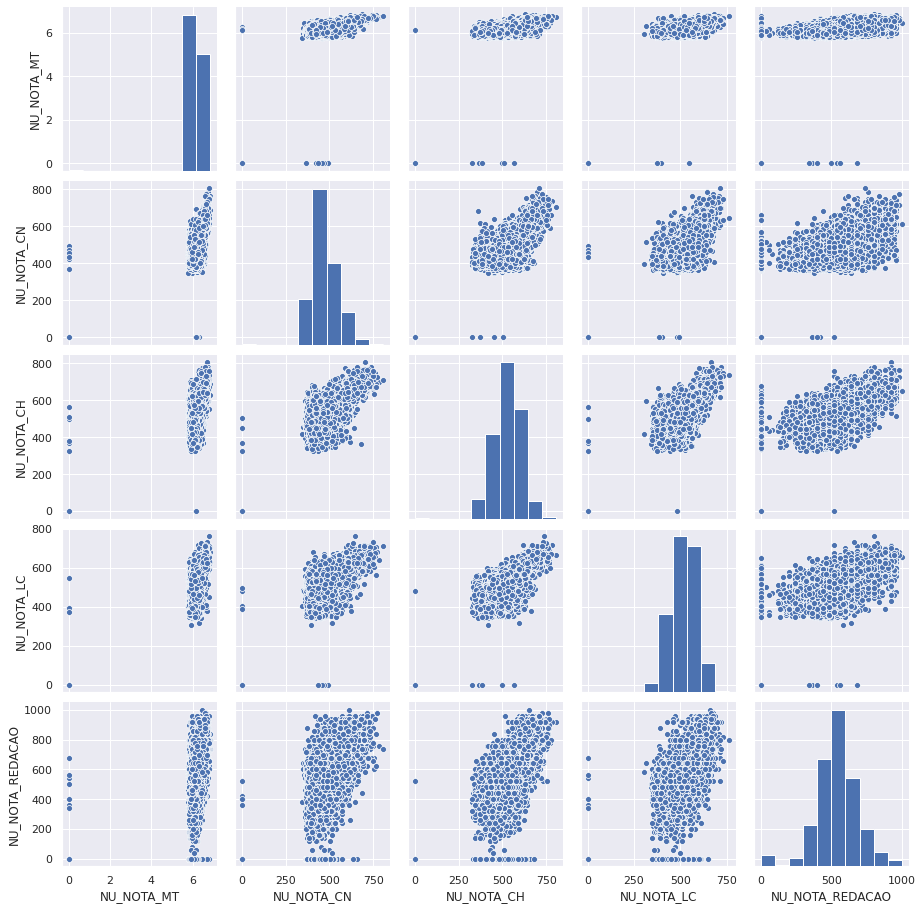

In [86]:
#scatterplot
sns.set()
selected_cols = [target_name, 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_REDACAO']
sns.pairplot(df_train_origin[selected_cols], height = 2.5)
plt.show();

In [87]:
def check_miss_data(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  
  return missing_data

In [88]:
#missing data
missing_data = check_miss_data(df_train)
missing_data.head(10)

,Total,Percent
NU_NOTA_MT,3597,0.261981
NU_NOTA_LC,3597,0.261981
NU_NOTA_REDACAO,3597,0.261981
NU_NOTA_COMP1,3597,0.261981
NU_NOTA_COMP5,3597,0.261981
NU_NOTA_CN,3389,0.246832
NU_NOTA_CH,3389,0.246832
Q047,0,0.000000
TP_COR_RACA,0,0.000000
TP_LINGUA,0,0.000000


In [89]:
#dealing with missing data
df_train_no_miss_data = df_train.drop(
    (missing_data[missing_data['Percent'] > 0.5]).index,1)
df_train_no_miss_data.head()


,NU_INSCRICAO,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP5,TP_LINGUA,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,SG_UF_RESIDENCIA,NU_IDADE,TP_ST_CONCLUSAO,TP_ESCOLA,Q001,Q002,Q006,Q024,Q025,Q026,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,399.4,436.3,495.4,581.2,520.0,120.0,80.0,1,M,1,1,RS,24,1,1,D,D,C,A,A,C,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,459.8,474.5,544.1,599.0,580.0,140.0,80.0,1,F,3,1,CE,17,2,2,A,A,B,A,A,A,A
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,F,3,1,CE,21,3,1,D,D,C,A,A,A,A
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,F,0,1,RJ,25,1,1,H,E,E,C,B,C,D
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,M,2,1,AM,28,1,1,E,D,C,A,A,B,A


In [90]:
col='NU_NOTA_CH'
df_train_no_miss_data = df_train_no_miss_data.drop(
    df_train_no_miss_data.loc[
      df_train_no_miss_data[col].isnull()].index)
#missing data
missing_data = check_miss_data(df_train_no_miss_data)
missing_data.head(10)

,Total,Percent
NU_NOTA_MT,244,0.023595
NU_NOTA_LC,244,0.023595
NU_NOTA_REDACAO,244,0.023595
NU_NOTA_COMP1,244,0.023595
NU_NOTA_COMP5,244,0.023595
Q047,0,0.000000
TP_COR_RACA,0,0.000000
NU_NOTA_CN,0,0.000000
NU_NOTA_CH,0,0.000000
TP_LINGUA,0,0.000000


In [91]:
df_train_no_miss_data = df_train_no_miss_data.drop(
    df_train_no_miss_data.loc[
      df_train_no_miss_data[target_name].isnull()].index)
#missing data
missing_data = check_miss_data(df_train_no_miss_data)
missing_data.head(10)

,Total,Percent
Q047,0,0.0
TP_COR_RACA,0,0.0
NU_NOTA_MT,0,0.0
NU_NOTA_CN,0,0.0
NU_NOTA_CH,0,0.0
NU_NOTA_LC,0,0.0
NU_NOTA_REDACAO,0,0.0
NU_NOTA_COMP1,0,0.0
NU_NOTA_COMP5,0,0.0
TP_LINGUA,0,0.0


In [92]:
df_train_no_miss_data.describe()

,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP5,TP_LINGUA,TP_COR_RACA,TP_NACIONALIDADE,NU_IDADE,TP_ST_CONCLUSAO,TP_ESCOLA
count,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000,10097.000000
mean,482.648638,473.912509,530.346123,516.665059,529.452907,119.880361,77.458156,0.579182,2.172427,1.045360,20.575517,1.810439,1.413192
std,99.685820,71.098468,73.528309,68.442602,154.001881,29.770060,43.057358,0.493715,1.004684,0.254754,6.345231,0.830838,0.591822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,1.000000
25%,409.000000,420.100000,481.000000,468.600000,440.000000,120.000000,40.000000,0.000000,1.000000,1.000000,17.000000,1.000000,1.000000
50%,461.300000,460.400000,532.600000,521.100000,540.000000,120.000000,80.000000,1.000000,3.000000,1.000000,18.000000,2.000000,1.000000
75%,537.700000,515.100000,581.900000,564.900000,600.000000,140.000000,100.000000,1.000000,3.000000,1.000000,21.000000,2.000000,2.000000
max,952.000000,806.400000,807.000000,763.600000,1000.000000,200.000000,200.000000,1.000000,5.000000,4.000000,66.000000,4.000000,4.000000


### Univariate analysis

In [93]:
#standardizing data
scale = StandardScaler()
notaMT_scaled = scale.fit_transform(
    df_train_no_miss_data[target_name][:,np.newaxis]);
low_range = notaMT_scaled[notaMT_scaled[:,0].argsort()][:10]
high_range= notaMT_scaled[notaMT_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-4.84193779]
 [-1.62667737]]

outer range (high) of the distribution:
[[4.14072735]
 [4.14173055]
 [4.14975616]
 [4.15677857]
 [4.27515633]
 [4.28217874]
 [4.35340604]
 [4.47278701]
 [4.5389983 ]
 [4.70853933]]


### Bivariate analysis

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

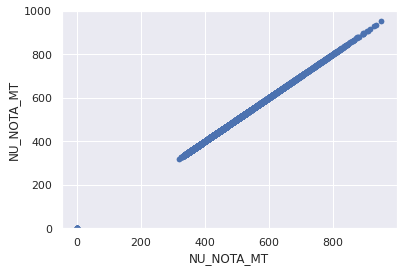

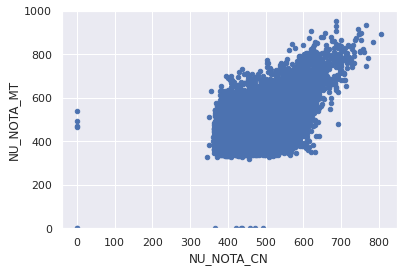

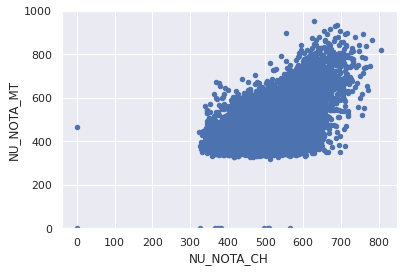

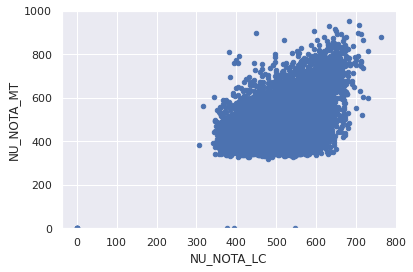

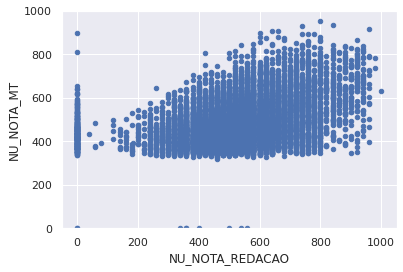

In [94]:
#bivariate analysis
for col in selected_cols:
  data = pd.concat([df_train_no_miss_data[target_name],
                  df_train_no_miss_data[col]], axis=1)
  data.plot.scatter(x=col, y=target_name, ylim=(0,1_000));

In [95]:
df_train_no_miss_data.sort_values(by=target_name, ascending = True)[:8]
col='NU_NOTA_CH'
df_train_no_miss_data.sort_values(by=col, ascending = True)
col='NU_NOTA_CN'
df_train_no_miss_data.sort_values(by=col, ascending = True)[:4]

,NU_INSCRICAO,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP5,TP_LINGUA,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,SG_UF_RESIDENCIA,NU_IDADE,TP_ST_CONCLUSAO,TP_ESCOLA,Q001,Q002,Q006,Q024,Q025,Q026,Q047
12120,26b8ddff19591d0e9127874e6764fbd71951b721,491.2,0.0,450.6,402.9,360.0,100.0,20.0,1,M,3,1,PE,20,2,2,C,C,B,A,A,A,A
111,6698841b20a8b8109a62ad87c39b775f9587acd0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,F,1,1,RS,44,4,1,B,B,C,A,A,C,A
10623,02a76b1bdf598f17d1e5beadaea03488affd7e83,540.1,0.0,505.4,494.8,420.0,120.0,40.0,0,M,3,1,RJ,18,2,2,E,D,D,B,B,A,A
13600,81fe4745b22b3a3f9653912c781e4e1f2c52e39e,0.0,0.0,326.2,0.0,400.0,120.0,40.0,0,M,1,1,PB,23,1,1,D,E,B,C,B,A,A


In [96]:
threshold = 1

for col in [target_name, 'NU_NOTA_CH', 'NU_NOTA_CN']:
  df_train_no_miss_data = df_train_no_miss_data[
                            df_train_no_miss_data[target_name] > threshold]


# Baseline

In [97]:
#convert categorical variable into dummy
df_train = pd.get_dummies(df_train)

In [98]:
from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

(10097, 4)
5950.816314550094


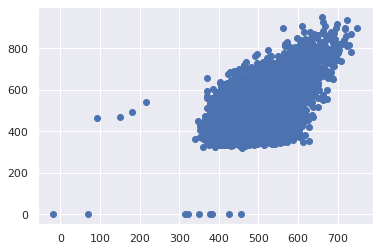

In [99]:
lm = LinearRegression()

df_train_sub = df_train[selected_cols]
df_train_sub = df_train_sub.dropna()

X = df_train_sub.drop([target_name], axis=1)
Y = df_train_sub[target_name]

print(X.shape)

lm.fit(X, Y)
yhat = lm.predict(X)
mse_y = np.mean((Y-yhat)**2)
print(mse_y)
plt.scatter(yhat,Y);

In [103]:
pd.DataFrame(zip(X.columns, lm.coef_), columns=['features','estimatedCoefficients'])

,features,estimatedCoefficients
0,NU_NOTA_CN,0.536988
1,NU_NOTA_CH,0.242628
2,NU_NOTA_LC,0.207742
3,NU_NOTA_REDACAO,0.020645


5950.816314550094


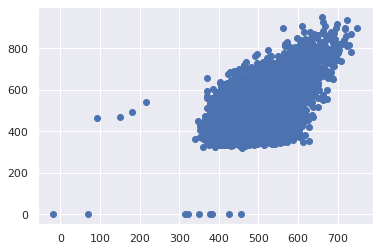

In [104]:
estimativeFULL = lm.predict(X)
plt.scatter(estimativeFULL,Y)
mseFull = np.mean((Y-estimativeFULL)**2)
print(mseFull)

In [106]:
df_test_sub = df_test[[idx_name,'NU_NOTA_CN','NU_NOTA_LC','NU_NOTA_CH','NU_NOTA_REDACAO']]
df_test_sub = df_test_sub.dropna()
X_test = df_test_sub.drop([idx_name],axis=1)

estimativeTest = lm.predict(X_test)

x1 = df_test[[idx_name]]
x3 = pd.DataFrame({idx_name:df_test_sub[idx_name],
                   target_name:estimativeTest})

results = pd.merge(x1, x3, how='left', on=idx_name)
print(x1)
print(x3)
print(results)
results.to_csv('answer.csv', index=False)


                                  NU_INSCRICAO
0     73ff9fcc02f0a99919906c942c2e1a1042cdcf98
1     71a95f9f1b91a82c65ad94abbdf9f54e6066f968
2     b38a03232f43b11c9d0788abaf060f7366053b6d
3     70b682d9a3636be23f6120fa9d6b164eb3c6002d
4     715494628a50142ce8cb17191cfe6d0f3cae0934
...                                        ...
4571  dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b
4572  a75fa8770257e7c9368d059fe53d9ef431f4bdef
4573  655fa6306720ff16e825903b5422a46608a77545
4574  1f4bc3e3d56212d500625bfe8ac78ccff4362293
4575  adf0d15b54317b6564ef56dad2b775bbb0ef50cc

[4576 rows x 1 columns]
                                  NU_INSCRICAO  NU_NOTA_MT
0     73ff9fcc02f0a99919906c942c2e1a1042cdcf98  436.386155
1     71a95f9f1b91a82c65ad94abbdf9f54e6066f968  438.195218
2     b38a03232f43b11c9d0788abaf060f7366053b6d  586.058038
4     715494628a50142ce8cb17191cfe6d0f3cae0934  547.180946
5     e656d6bad65c93fb2880f1eba5037008c8e75774  465.092607
...                                        ...         ..

Text(0, 0.5, 'Residuals')

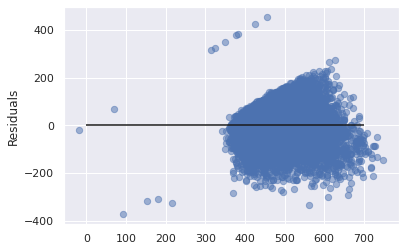

In [108]:
plt.scatter(yhat, yhat-Y, c='b', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=700)
plt.ylabel('Residuals')

In [109]:
print(X)
print(Y)

       NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_REDACAO
0           436.3       495.4       581.2            520.0
1           474.5       544.1       599.0            580.0
5           439.7       583.2       410.9            620.0
6           420.1       604.2       484.5            560.0
7           619.6       625.8       611.2            620.0
...           ...         ...         ...              ...
13725       438.2       419.7       394.5            440.0
13726       423.8       557.9       533.0            560.0
13727       460.5       528.9       569.3            600.0
13728       422.5       621.7       569.0            460.0
13729       488.7       575.3       565.9            520.0

[10097 rows x 4 columns]
0        399.4
1        459.8
5        364.5
6        529.2
7        566.7
         ...  
13725    403.2
13726    452.4
13727    398.0
13728    386.6
13729    428.9
Name: NU_NOTA_MT, Length: 10097, dtype: float64


(10097, 1)
7530.759448579293


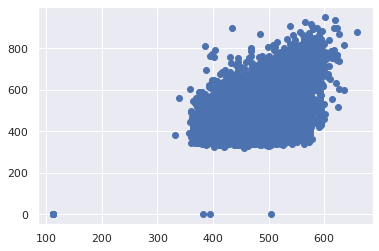

In [122]:
lm = LinearRegression()

df_train_sub = df_train.dropna()

X = df_train_sub[['NU_NOTA_LC']].to_numpy().reshape(-1, 1)
Y = df_train_sub[target_name]

print(X.shape)

lm.fit(X, Y)
yhat = lm.predict(X)
mse_y = np.mean((Y-yhat)**2)
print(mse_y)
plt.scatter(yhat,Y);